**Imports & Settings**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)

**Load Clean Dataset**

In [ ]:
df = pd.read_csv("/content/master_dataset.csv")

In [ ]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Industry code             176 non-null    float64
 1   sector                    208 non-null    object 
 2   year                      208 non-null    int64  
 3   sector_output             208 non-null    float64
 4   rgdpo                     208 non-null    float64
 5   emp                       208 non-null    float64
 6   rkna                      208 non-null    float64
 7   avh                       208 non-null    float64
 8   gdp_per_worker            208 non-null    float64
 9   capital_per_worker        208 non-null    float64
 10  output_per_worker         208 non-null    float64
 11  output_per_hour           208 non-null    float64
 12  sector_output_growth      207 non-null    float64
 13  output_per_worker_growth  207 non-null    float64
 14  output_per

Create economy-wide productivity (average across sectors)**bold text**

In [ ]:
prod_agg = (
    df.groupby("year")["output_per_worker"]
      .mean()
      .reset_index()
      .rename(columns={"output_per_worker": "prod"})
)

**Trend–Cycle Decomposition (CORE DSGE STEP)**

**Apply HP filter (annual data → λ = 100)**

In [ ]:
prod_cycle, prod_trend = hpfilter(prod_agg["prod"], lamb=100)

prod_agg["prod_trend"] = prod_trend
prod_agg["prod_cycle"] = prod_cycle

**Visualise Trend vs Cycle**

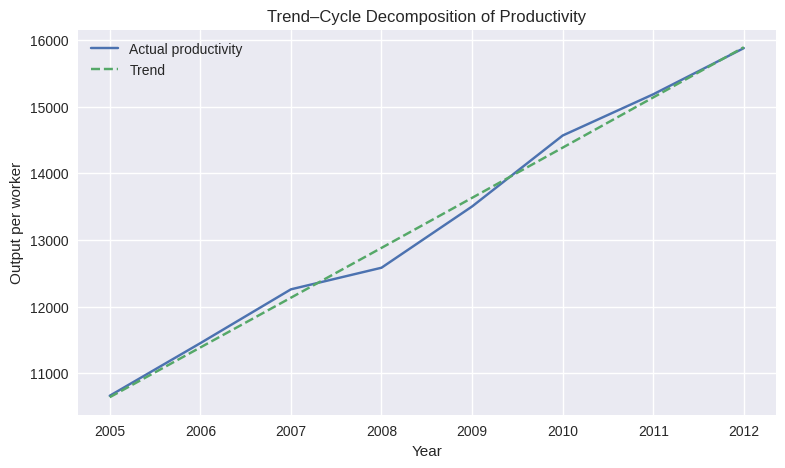

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(prod_agg["year"], prod_agg["prod"], label="Actual productivity")
plt.plot(prod_agg["year"], prod_agg["prod_trend"], label="Trend", linestyle="--")
plt.title("Trend–Cycle Decomposition of Productivity")
plt.xlabel("Year")
plt.ylabel("Output per worker")
plt.legend()
plt.show()

**Define Shock Threshold**

In [ ]:
threshold = 1.5 * prod_agg["prod_cycle"].std()
threshold

227.84448560138395

**Identify Shock Years**

In [ ]:
prod_agg["prod_shock"] = (
    prod_agg["prod_cycle"].abs() > threshold
).astype(int)

prod_agg["shock_type"] = np.where(
    prod_agg["prod_cycle"] > threshold, "Positive",
    np.where(prod_agg["prod_cycle"] < -threshold, "Negative", "None")
)

In [ ]:
prod_agg[prod_agg["prod_shock"] == 1]

,year,prod,prod_trend,prod_cycle,prod_shock,shock_type
3,2008,12582.15,12880.144774,-297.994774,1,Negative


**Visualise Shocks (CONFIRMATION)**

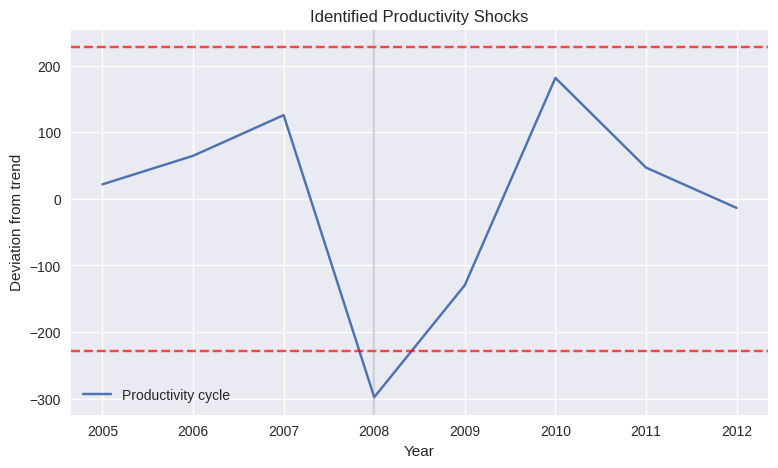

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(prod_agg["year"], prod_agg["prod_cycle"], label="Productivity cycle")
plt.axhline(threshold, linestyle="--", color="red", alpha=0.7)
plt.axhline(-threshold, linestyle="--", color="red", alpha=0.7)

shock_years = prod_agg[prod_agg["prod_shock"] == 1]["year"]
for y in shock_years:
    plt.axvline(y, color="grey", alpha=0.3)

plt.title("Identified Productivity Shocks")
plt.xlabel("Year")
plt.ylabel("Deviation from trend")
plt.legend()
plt.show()

**Merge Shocks Back to Sector-Level Data**

In [ ]:
df = df.merge(
    prod_agg[["year", "prod_shock", "shock_type"]],
    on="year",
    how="left"
)

In [ ]:
df[["year", "sector", "prod_shock", "shock_type"]].head()

,year,sector,prod_shock,shock_type
0,2005,Basic metals,0,None
1,2006,Basic metals,0,None
2,2007,Basic metals,0,None
3,2008,Basic metals,1,Negative
4,2009,Basic metals,0,None


**Save Shock-Annotated Dataset**

In [ ]:
import os

os.makedirs("../outputs", exist_ok=True)
df.to_csv("../outputs/master_with_shocks.csv", index=False)

In [ ]:
shock_years = (
    df.loc[df["prod_shock"] == 1, ["year", "output_per_worker_growth"]]
    .drop_duplicates()
    .rename(columns={"output_per_worker_growth": "shock_magnitude"})
    .sort_values("year")
)

shock_years.to_csv("../outputs/shock_years.csv", index=False)